In [ ]:
#!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=d195b07e984dbcdf6e2ed3a6a40525fa3b01b2dffcbeac35713146de639c8e9a
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=b7fd45ff7b77354f191001214aadbca650bc3a94c0de87e4e252caf501e1275d
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import torch

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt
import torch.nn.functional as F

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets

In [ ]:
MNIST_train=torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test=torchvision.datasets.MNIST('./', download = True, train = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 230683973.88it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 93324879.68it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71484298.19it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19262415.34it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Автокодировщик на свертках для данных с шумом

In [ ]:
X_train = MNIST_train.train_data/255
X_test = MNIST_test.train_data/255

noise = 0.5 

X_train_noise = X_train + noise * np.random.normal(loc = 0, scale=1 ,size = X_train.shape)
X_test_noise = X_test + noise * np.random.normal(loc = 0, scale=1 ,size = X_test.shape)

X_train=X_train.to(torch.float32) 
X_test=X_test.to(torch.float32)
X_train_noise=X_train_noise.to(torch.float32) 
X_test_noise=X_test_noise.to(torch.float32)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Данные с шумом мы используем для входа в сеть, а данные без шума - для оценки качества результата

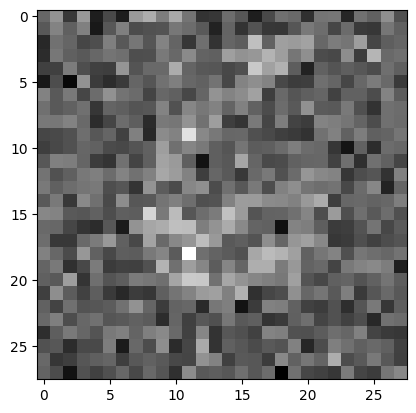

In [ ]:
plt.imshow(X_train_noise[90], cmap='gray')

In [ ]:
X_train_noise.shape

torch.Size([60000, 28, 28])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 4, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2) 
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.pool(x)
      return x

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(4, 16, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 1, 3, padding=1)
        self.relu = torch.nn.ReLU()
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = F.upsample(x, scale_factor=2, mode='nearest')
      x = self.conv1(x)
      x = self.relu(x)
      x = F.upsample(x, scale_factor=2, mode='nearest')
      x = self.conv2(x)
      x = self.relu(x)
      return x
    
    def predict(self, x): 
      x = self.forward(x)
      return x

In [ ]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
    encoder.train()
    decoder.train()
    print('Обучение автокодировщика..')
    loss = torch.nn.MSELoss()
    opt = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)
    loss_history = list()
    for epoch in range(epochs):
        for (batch, val) in data_loader:
          opt.zero_grad()
          batch = batch.to(device)
          loss_val = loss(decoder(encoder((batch))), val.to(device))
          loss_val.backward()
          opt.step()
          loss_history.append(loss_val.log().item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss_val.item()}')
    print('Готово!')
    encoder.eval()
    decoder.eval()
    plt.plot(loss_history)
    plt.show()

In [ ]:
encoder_cv = Encoder().to(device)
decoder_cv = Decoder().to(device)

In [ ]:
all_data = []
for i in range(len(X_train_noise)):
  all_data.append([X_train_noise[i].unsqueeze(0),X_train[i].unsqueeze(0)])

In [ ]:
train_data_loader_cv = DataLoader(dataset=all_data,
                              batch_size=256,
                              shuffle=True)

Обучение автокодировщика..


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Эпоха 1 / 10. Потери на последнем пакете: 0.033303480595350266
Эпоха 2 / 10. Потери на последнем пакете: 0.029402483254671097
Эпоха 3 / 10. Потери на последнем пакете: 0.025798611342906952
Эпоха 4 / 10. Потери на последнем пакете: 0.02709457091987133
Эпоха 5 / 10. Потери на последнем пакете: 0.02791101671755314
Эпоха 6 / 10. Потери на последнем пакете: 0.027712782844901085
Эпоха 7 / 10. Потери на последнем пакете: 0.028659217059612274
Эпоха 8 / 10. Потери на последнем пакете: 0.026615604758262634
Эпоха 9 / 10. Потери на последнем пакете: 0.02727251499891281
Эпоха 10 / 10. Потери на последнем пакете: 0.026617709547281265
Готово!


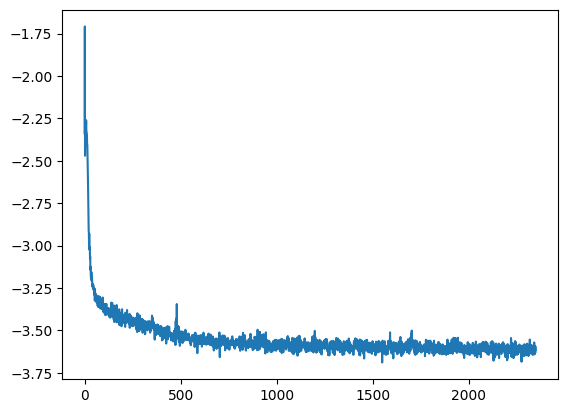

In [ ]:
EPOCHS=10
LR=0.01
train_ae(train_data_loader_cv, encoder_cv, decoder_cv, EPOCHS, LR)

In [ ]:
result = decoder_cv.predict(encoder_cv(X_test_noise[:6].unsqueeze(1).to(device)))

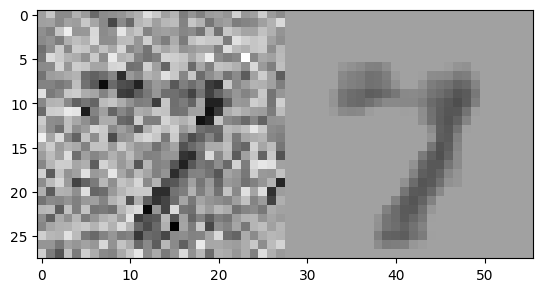

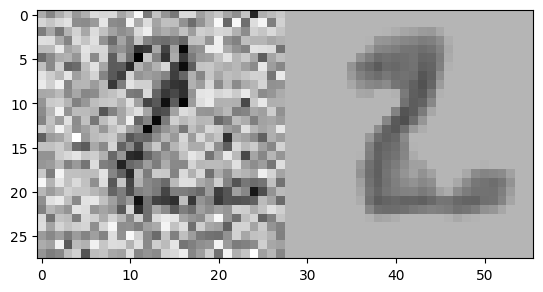

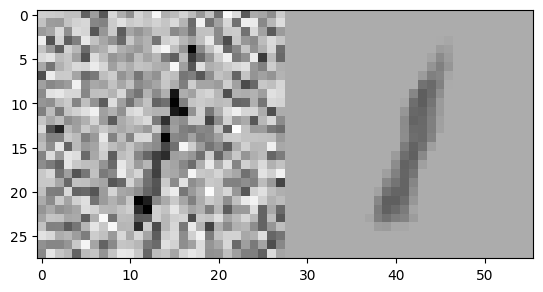

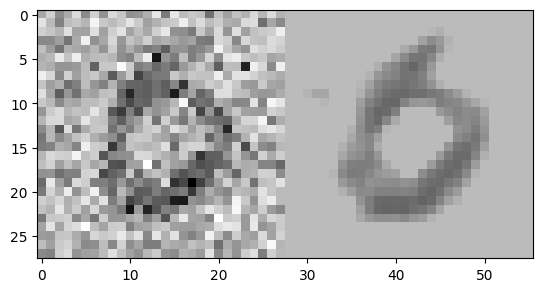

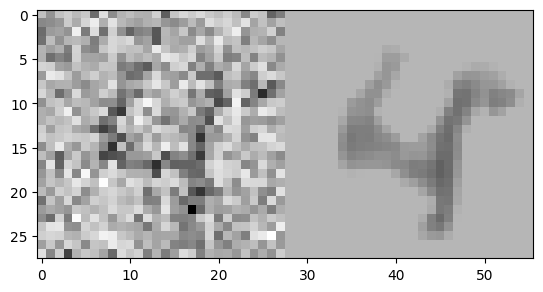

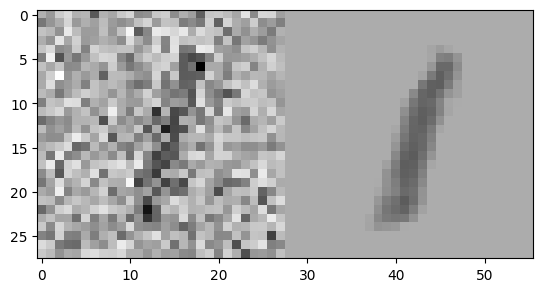

In [ ]:
for i in range(result.shape[0]):
    orig_restored = torch.hstack((X_test_noise[i].unsqueeze(2), result[i].detach().cpu().permute(1,2,0)))
    plt.imshow(orig_restored.numpy(), cmap='Greys')
    plt.show()

In [ ]:
# Посмотрим на скрытое пространство
for_result = X_test_noise.unsqueeze(1).to(device)

In [ ]:
#Получим скрытое состояние для каждого объекта
result = encoder_cv(for_result)

In [ ]:
result.shape

torch.Size([10000, 4, 7, 7])

In [ ]:
result=result.view(result.shape[0],result.shape[1]*result.shape[2]*result.shape[3])

In [ ]:
result=pd.DataFrame(result.detach().cpu().numpy())

In [ ]:
import umap
import seaborn as sns

In [ ]:
a=umap.UMAP(random_state=123).fit_transform(result)

In [ ]:
d = {'col1': a[:,0], 'col2': a[:,1]}
a = pd.DataFrame(data=d)

In [ ]:
a['label'] = MNIST_test.test_labels
print(a)

           col1       col2  label
0      9.020082   9.639231      7
1      7.385625   2.685241      2
2     11.956489   6.321423      1
3      1.150745   2.790944      0
4      5.087416  11.251723      4
...         ...        ...    ...
9995   6.461554   2.703284      2
9996   4.133241   3.568836      3
9997   6.711151   8.679094      4
9998   7.840203   5.306356      5
9999   1.002223   7.664547      6

[10000 rows x 3 columns]


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


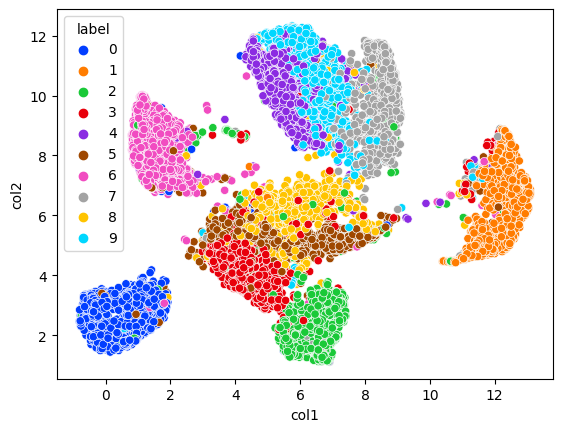

In [ ]:
fig = plt.figure()
sns.scatterplot(x='col1',y='col2',data=a, palette='bright', hue=a['label'])
plt.show()